# 03 — BERT for Crisis Tweets
- **Задача и данные**. Бинарная классификация твитов о ЧС: Related & informative vs Not informative. Используется подготовленный train/dev/test из предыдущего ноутбука (около 5k примеров в тесте), тексты токенизируются без жёсткого препроцесса, max_len фиксируется.

- **Модель и стек**. PyTorch + Transformers: AutoModelForSequenceClassification на базе BERT base uncased. Токенизация AutoTokenizer. Логирование экспериментов и артефактов — MLflow (кривые обучения, ROC, метрики, сериализованная модель). Вспомогательно: NumPy, pandas, scikit-learn (метрики и ROC).

- **Тренировка**. Оптимизатор AdamW, линейный learning-rate scheduler с warmup, weight decay=0.01, mixed precision (GradScaler), батчи через DataLoader. Дисбаланс классов учитывается весами классов в CrossEntropyLoss. Сохраняется лучшее состояние модели по вал.метрике.

- **Оценка**. Метрики: accuracy/precision/recall/F1, ROC-AUC, confusion matrix. Порог для инференса подбирается по максимуму F1 на валидации (≈0.47). Финальная проверка на тесте: AUC≈0.933, accuracy≈0.86, F1 (weighted) ≈ 0.86 — результаты близки к валидации, признаков переобучения нет.

- **Артефакты и воспроизводимость**. В MLflow логируются гиперпараметры (lr, batch size, epochs, max_len), кривые обучения, ROC, отчёт по метрикам и сохранённая PyTorch-модель с сигнатурой/примером входа для последующего деплоя.


In [ ]:
!pip -q install transformers mlflow accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22

In [ ]:
import os, re, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.pytorch
from mlflow.models import infer_signature

# --- Reproducibility ---
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds(42)

# --- MLflow локально ---
BASE_DIR = os.getcwd()
TRACKING_DIR = os.path.join(BASE_DIR, "mlruns")
os.makedirs(TRACKING_DIR, exist_ok=True)
mlflow.set_tracking_uri(pathlib.Path(TRACKING_DIR).absolute().as_uri())
mlflow.set_experiment("BERT_Finetune")
print("MLflow tracking ->", mlflow.get_tracking_uri())

MLflow tracking -> file:///content/mlruns


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DATA_DIR = "/content/drive/MyDrive/crisis_lstm"
CAT = "ALL"   # можно указать тип события: 'Earthquake', 'Floods', ...

def _cname(x): return re.sub(r'[^A-Za-z0-9_]+','_', str(x))

if CAT == "ALL":
    train_path = f"{DATA_DIR}/train_data.csv"
    test_path  = f"{DATA_DIR}/test_data.csv"
else:
    cname = _cname(CAT)
    train_path = f"{DATA_DIR}/train_{cname}.csv"
    test_path  = f"{DATA_DIR}/test_{cname}.csv"

df_train_full = pd.read_csv(train_path)
df_test       = pd.read_csv(test_path)

assert {'text','label'}.issubset(df_train_full.columns)
assert {'text','label'}.issubset(df_test.columns)
print('Loaded:', df_train_full.shape, df_test.shape)
print('Train pos ratio:', round(df_train_full['label'].mean(), 3))

Mounted at /content/drive
Loaded: (19835, 2) (4959, 2)
Train pos ratio: 0.605


In [ ]:
# ---- Train/Dev split (stratified) ----
df_tr, df_dev = train_test_split(
    df_train_full, test_size=0.15, stratify=df_train_full['label'], random_state=42
)

print("Train/Dev/Test:", df_tr.shape, df_dev.shape, df_test.shape)

Train/Dev/Test: (16859, 2) (2976, 2) (4959, 2)


In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 160
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class TweetsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = np.array(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TweetsDataset(df_tr["text"],  df_tr["label"],  tokenizer, MAX_LEN)
dev_ds   = TweetsDataset(df_dev["text"], df_dev["label"], tokenizer, MAX_LEN)
test_ds  = TweetsDataset(df_test["text"], df_test["label"], tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(dev_ds), len(test_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(16859, 2976, 4959)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

# class weights (handle imbalance)
pos_ratio = float(df_tr["label"].mean())
w1 = 1.0 / max(pos_ratio, 1e-6)
w0 = 1.0 / max(1.0 - pos_ratio, 1e-6)
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

LR = 1e-5
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
num_training_steps = EPOCHS * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)
scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
print("Device:", device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


/tmp/ipython-input-572134792.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


In [ ]:
def train_epoch(model, loader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss, total, correct = 0.0, 0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", enabled=(device=="cuda")):
            outputs = model(**batch, labels=None)
            logits = outputs.logits
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / max(1,total), correct / max(1,total)

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        outputs = model(**batch, labels=None)
        logits = outputs.logits
        loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        probs = torch.softmax(logits, dim=-1)[:, 1]
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    y_prob = np.concatenate(all_probs)
    y_true = np.concatenate(all_labels)

    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
    mauc = auc(fpr, tpr)
    acc = correct / max(1,total)
    return total_loss / max(1,total), acc, y_true, y_prob, (fpr, tpr, mauc)

def log_metrics(y_true, y_prob, mlflow_client=None, prefix="val"):
    y_bin = (y_prob > 0.5).astype(int)
    acc  = accuracy_score(y_true, y_bin)
    pre  = precision_score(y_true, y_bin, zero_division=0)
    rec  = recall_score(y_true, y_bin, zero_division=0)
    f1   = f1_score(y_true, y_bin, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    mauc = auc(fpr, tpr)
    print(classification_report(
        y_true, y_bin,
        target_names=['Not informative','Related and informative']
    ))
    if mlflow_client:
        mlflow.log_metric(f"{prefix}_accuracy",  float(acc))
        mlflow.log_metric(f"{prefix}_precision", float(pre))
        mlflow.log_metric(f"{prefix}_recall",    float(rec))
        mlflow.log_metric(f"{prefix}_f1",        float(f1))
        mlflow.log_metric(f"{prefix}_mAUC",      float(mauc))
    return acc, pre, rec, f1, mauc

[1/2] train_loss=0.4420 acc=0.8012 | val_loss=0.3723 acc=0.8569 AUC=0.9273
[2/2] train_loss=0.3118 acc=0.8716 | val_loss=0.3499 acc=0.8666 AUC=0.9326


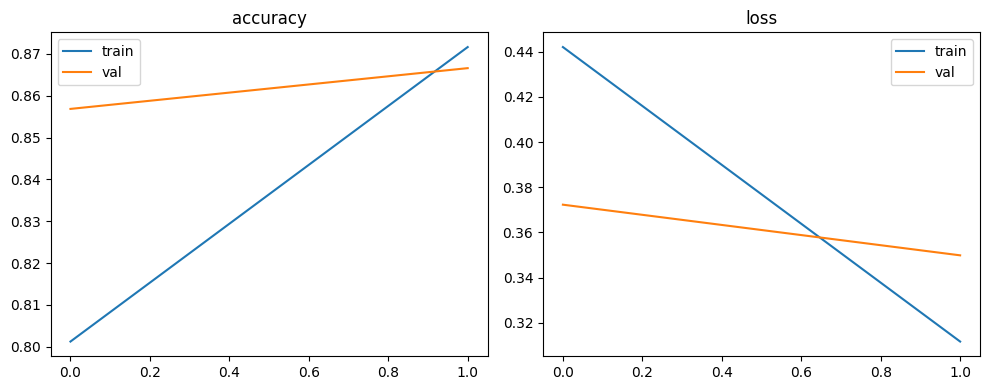

                         precision    recall  f1-score   support

        Not informative       0.82      0.82      0.82      1961
Related and informative       0.88      0.88      0.88      2998

               accuracy                           0.86      4959
              macro avg       0.85      0.85      0.85      4959
           weighted avg       0.86      0.86      0.86      4959



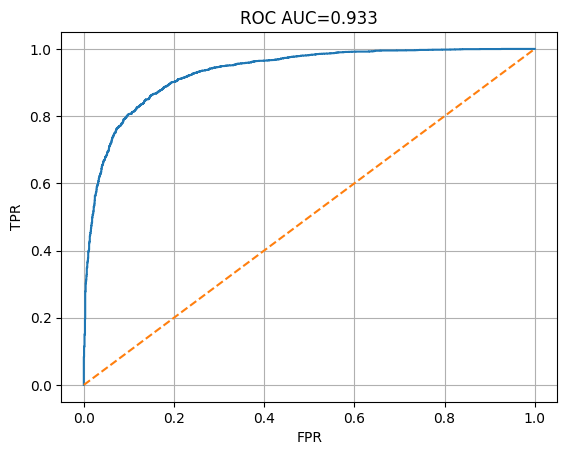

2025/10/07 11:52:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 11:52:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 11:52:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 11:52:58 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "input_ids": [
  

In [ ]:
# ---- Train/Validation ----

run_name = f"BERT_{CAT}_bs{BATCH_SIZE}_ep{EPOCHS}_maxlen{MAX_LEN}"
with mlflow.start_run(run_name=run_name):
    mlflow.log_params({
        "model_name": MODEL_NAME,
        "category": CAT,
        "max_len": MAX_LEN,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": 0.01
    })

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val = -1.0
    best_state = None

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, scheduler, scaler, device)
        val_loss, val_acc, y_true_val, y_prob_val, (fpr, tpr, mauc_val) = eval_epoch(model, dev_loader, device)

        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(val_loss);   hist["val_acc"].append(val_acc)

        print(f"[{ep}/{EPOCHS}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} AUC={mauc_val:.4f}")
        mlflow.log_metrics({
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_loss": val_loss, "val_acc": val_acc, "val_mAUC": mauc_val
        }, step=ep)

        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Кривые обучения
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(hist["train_acc"], label="train"); ax[0].plot(hist["val_acc"], label="val"); ax[0].set_title("accuracy"); ax[0].legend()
    ax[1].plot(hist["train_loss"], label="train"); ax[1].plot(hist["val_loss"], label="val"); ax[1].set_title("loss"); ax[1].legend()
    plt.tight_layout(); plt.show()
    mlflow.log_figure(fig, "training_curves.png")

    # Лучшая модель
    if best_state is not None:
        model.load_state_dict(best_state)

    # Финальная оценка на тесте
    test_loss, test_acc, y_true, y_prob, (fpr, tpr, mauc) = eval_epoch(model, test_loader, device)
    acc, pre, rec, f1, mauc = log_metrics(y_true, y_prob, mlflow, prefix="test")

    # ROC кривая
    fig = plt.figure()
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC AUC={mauc:.3f}'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(True)
    plt.show()
    mlflow.log_figure(fig, "roc_curve.png")

    # ---- Лог модели в MLflow ----
    ex = tokenizer("example text",
                   return_tensors="pt", padding="max_length",
                   truncation=True, max_length=MAX_LEN)
    ex_cpu_np = {k: v.detach().cpu().numpy() for k, v in ex.items()}

    model.eval()
    with torch.no_grad():
        out = model(**{k: v.to(device) for k, v in ex.items()})
    logits_np = out.logits.detach().cpu().numpy()

    sig = infer_signature(ex_cpu_np, logits_np)

    mlflow.pytorch.log_model(
        model,
        artifact_path="BERT_model",
        signature=sig,
        input_example={k: v.tolist() for k, v in ex_cpu_np.items()}
    )

[TEST] AUC=0.933 | best_thr=0.470 | best_F1=0.8924

=== Classification report (TEST) ===
                         precision    recall  f1-score   support

        Not informative       0.83      0.81      0.82      1961
Related and informative       0.88      0.89      0.89      2998

               accuracy                           0.86      4959
              macro avg       0.86      0.85      0.85      4959
           weighted avg       0.86      0.86      0.86      4959



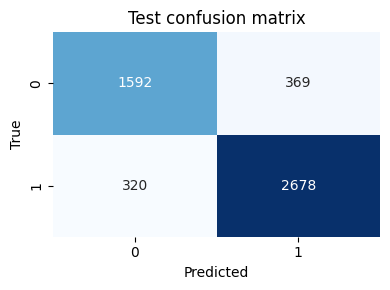

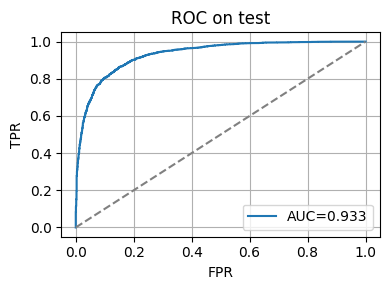

In [ ]:
# ---- Test ----

# На TEST подберём порог, который максимизирует F1
dev_loss, dev_acc, y_true_dev, y_prob_dev, (fpr_dev, tpr_dev, auc_dev) = eval_epoch(model, dev_loader, device)

thr_grid = np.linspace(0.05, 0.95, 181)  # шаг 0.005
f1s = [f1_score(y_true_dev, (y_prob_dev >= t).astype(int)) for t in thr_grid]
best_thr = thr_grid[int(np.argmax(f1s))]

mlflow.log_metric("dev_auc", float(auc_dev))
mlflow.log_metric("dev_f1_at_best_thr", float(np.max(f1s)))
mlflow.log_metric("best_threshold", float(best_thr))

print(f"[TEST] AUC={auc_dev:.3f} | best_thr={best_thr:.3f} | best_F1={np.max(f1s):.4f}")

# Финальная оценка на TEST
test_loss, test_acc, y_true_test, y_prob_test, (fpr_test, tpr_test, auc_test) = eval_epoch(model, test_loader, device)
y_pred_test = (y_prob_test >= best_thr).astype(int)

acc = accuracy_score(y_true_test, y_pred_test)
pre = precision_score(y_true_test, y_pred_test)
rec = recall_score(y_true_test, y_pred_test)
f1  = f1_score(y_true_test, y_pred_test)

print("\n=== Classification report (TEST) ===")
print(classification_report(
    y_true_test, y_pred_test,
    target_names=["Not informative", "Related and informative"]
))

mlflow.log_metrics({
    "test_loss": float(test_loss),
    "test_acc": float(acc),
    "test_precision": float(pre),
    "test_recall": float(rec),
    "test_f1": float(f1),
    "test_auc": float(auc_test),
})

# Confusion matrix (TEST)
cm = confusion_matrix(y_true_test, y_pred_test)
fig_cm, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Test confusion matrix")
plt.tight_layout(); plt.show()
mlflow.log_figure(fig_cm, "test_confusion_matrix.png")

# ROC-кривая (TEST)
fig_roc = plt.figure(figsize=(4,3))
plt.plot(fpr_test, tpr_test, label=f"AUC={auc_test:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC on test")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
mlflow.log_figure(fig_roc, "test_roc.png")